In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split # Import the missing function

In [ ]:
# Load and prepare the data
data_series_raw = pd.read_csv('/content/sample_data/data_terpakai.csv')  # Adjust path as needed
data_series_raw['datetime'] = pd.to_datetime(data_series[['year', 'month', 'day', 'hour']])
data_series_raw.set_index('datetime', inplace=True)
data_series_raw.sort_index(inplace=True)

In [ ]:
data_series_raw.head()

,timestamp,lat,lon,is_powered_on,year,month,day,hour,minute,second,...,Emisi_Bulanan_NOx_1A,Emisi_Tahunan_NOx_1A,Emisi_Bulanan_CH4_1A,Emisi_Tahunan_CH4_1A,Emisi_Bulanan_CO2_1B,Emisi_Tahunan_CO2_1B,Emisi_Bulanan_NOx_1B,Emisi_Tahunan_NOx_1B,Emisi_Bulanan_CH4_1B,Emisi_Tahunan_CH4_1B
datetime,,,,,,,,,,,,,,,,,,,,,
NaT,2021-03-04 09:23:32,-6.29458,107.29586,1,2021,3,4,9,23,32,...,894000,10877000,15000,182500,171153.792,2082371.136,894000,10877000,15000,182500
NaT,2021-04-04 13:31:24,-6.29458,107.29586,0,2021,4,4,13,31,24,...,894000,10877000,15000,182500,128365.344,1561778.352,894000,10877000,15000,182500
NaT,2021-05-18 09:03:58,-6.29458,107.29586,0,2021,5,18,9,3,58,...,894000,10877000,15000,182500,160456.680,1952222.940,894000,10877000,15000,182500
NaT,2021-06-30 14:25:21,-6.29458,107.29586,0,2021,6,30,14,25,21,...,894000,10877000,15000,182500,160456.680,1952222.940,894000,10877000,15000,182500
NaT,2021-07-10 13:00:29,-6.29458,107.29586,0,2021,7,10,13,0,29,...,894000,10877000,15000,182500,160456.680,1952222.940,894000,10877000,15000,182500


In [ ]:
data_series_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85 entries, NaT to NaT
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                85 non-null     object 
 1   lat                      85 non-null     float64
 2   lon                      85 non-null     float64
 3   is_powered_on            85 non-null     int64  
 4   year                     85 non-null     int64  
 5   month                    85 non-null     int64  
 6   day                      85 non-null     int64  
 7   hour                     85 non-null     int64  
 8   minute                   85 non-null     int64  
 9   second                   85 non-null     int64  
 10  country_code             85 non-null     object 
 11  city                     85 non-null     object 
 12  latitude                 85 non-null     float64
 13  longitude                85 non-null     float64
 14  population            

In [ ]:
data_series = data_series_raw.drop(data_series.iloc[:, 30:43], axis=1)

In [ ]:
data_series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85 entries, NaT to NaT
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                85 non-null     object 
 1   lat                      85 non-null     float64
 2   lon                      85 non-null     float64
 3   is_powered_on            85 non-null     int64  
 4   year                     85 non-null     int64  
 5   month                    85 non-null     int64  
 6   day                      85 non-null     int64  
 7   hour                     85 non-null     int64  
 8   minute                   85 non-null     int64  
 9   second                   85 non-null     int64  
 10  country_code             85 non-null     object 
 11  city                     85 non-null     object 
 12  latitude                 85 non-null     float64
 13  longitude                85 non-null     float64
 14  population            

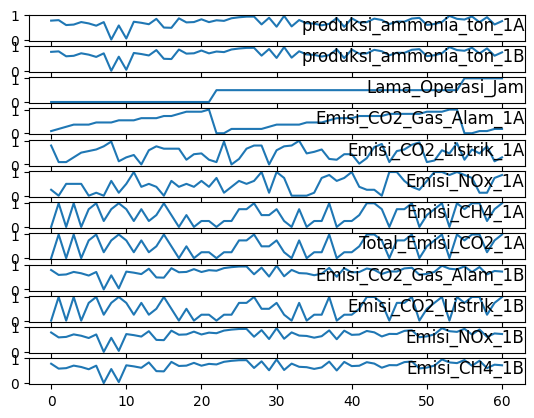

In [ ]:
from matplotlib import pyplot
# specify columns to plot
groups = [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
i = 1
# plot each column
pyplot.figure()
for group in groups:
 pyplot.subplot(len(groups), 1, i)
 pyplot.plot(values[:, group])
 pyplot.title(data_series.columns[group], y=0.1, loc='right')
 i += 1
pyplot.show()

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
      agg.dropna(inplace=True)
    return agg

In [ ]:
from sklearn.preprocessing import LabelEncoder
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]], axis=1, inplace=True)
print(reframed.head())

   var19(t-1)  var20(t-1)  var21(t-1)  var22(t-1)  var23(t-1)  var24(t-1)  \
1    0.798224    0.798223         0.0    0.090909         0.8        0.25   
2    0.819045    0.819045         0.0    0.181818         0.1        0.00   
3    0.611246    0.611246         0.0    0.272727         0.1        0.50   
4    0.631755    0.631755         0.0    0.363636         0.3        0.50   
5    0.738523    0.738524         0.0    0.363636         0.5        0.50   

   var25(t-1)  var26(t-1)  var27(t-1)  var28(t-1)  ...  var234(t)  var235(t)  \
1         0.0         0.0    0.819045         0.0  ...      0.750       0.00   
2         1.0         1.0    0.611246         1.0  ...      0.125       0.25   
3         0.0         0.0    0.631755         0.0  ...      0.375       0.25   
4         1.0         1.0    0.738523         1.0  ...      0.625       0.75   
5         0.0         0.0    0.680711         0.0  ...      0.500       0.75   

   var236(t)  var237(t)  var238(t)  var239(t)  var240(t)

In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = 4 * 12
split_point = int(len(values) * 0.8)
train = values[:split_point, :] # Use split_point to split data
test = values[split_point:, :]
# split into input and outputs
train_X, train_y = train[:, :-3], train[:, -3:] # Split the last 3 columns as outputs
test_X, test_y = test[:, :-3], test[:, -3:] # Split the last 3 columns as outputs
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1])) # Reshape test_X in the same way as train_X
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(48, 1, 465) (48, 3) (12, 1, 465) (12, 3)


Epoch 1/50
1/1 - 3s - loss: 0.5590 - val_loss: 0.2450 - 3s/epoch - 3s/step
Epoch 2/50
1/1 - 0s - loss: 0.2595 - val_loss: 0.1083 - 53ms/epoch - 53ms/step
Epoch 3/50
1/1 - 0s - loss: 0.1174 - val_loss: 0.1008 - 44ms/epoch - 44ms/step
Epoch 4/50
1/1 - 0s - loss: 0.0899 - val_loss: 0.1356 - 43ms/epoch - 43ms/step
Epoch 5/50
1/1 - 0s - loss: 0.1202 - val_loss: 0.1553 - 51ms/epoch - 51ms/step
Epoch 6/50
1/1 - 0s - loss: 0.1342 - val_loss: 0.1512 - 46ms/epoch - 46ms/step
Epoch 7/50
1/1 - 0s - loss: 0.1207 - val_loss: 0.1332 - 58ms/epoch - 58ms/step
Epoch 8/50
1/1 - 0s - loss: 0.1182 - val_loss: 0.1114 - 53ms/epoch - 53ms/step
Epoch 9/50
1/1 - 0s - loss: 0.0943 - val_loss: 0.0938 - 68ms/epoch - 68ms/step
Epoch 10/50
1/1 - 0s - loss: 0.0769 - val_loss: 0.0826 - 63ms/epoch - 63ms/step
Epoch 11/50
1/1 - 0s - loss: 0.0715 - val_loss: 0.0781 - 50ms/epoch - 50ms/step
Epoch 12/50
1/1 - 0s - loss: 0.0741 - val_loss: 0.0784 - 50ms/epoch - 50ms/step
Epoch 13/50
1/1 - 0s - loss: 0.0756 - val_loss: 0.081

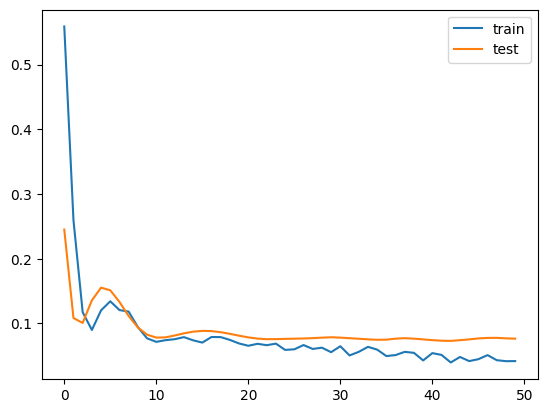

In [ ]:
from keras.layers import Dropout
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(3))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
test_y.shape

(12, 3)

In [ ]:
test_X.shape

(12, 1, 465)

In [ ]:
# Make predictions
Y_pred = model.predict(test_X)

# Inverse transform predictions
Y_pred = scaler_Y.inverse_transform(Y_pred)

# Inverse transform test labels
Y_test = scaler_Y.inverse_transform(test_y) # Reshape test_y to a 2D array

1/1 [==============================] - 0s 402ms/step


In [ ]:
Y_test

array([[  5626.2417,   5925.3076, 390783.62  ],
       [  5565.5674,   6111.241 , 173872.7   ],
       [  5275.327 ,   5388.3633, 321873.25  ],
       [  5301.2593,   6266.7456, 306991.7   ]], dtype=float32)

In [ ]:
Y_pred

array([[  5355.5713,   5545.664 , 345784.4   ],
       [  5464.5176,   5703.209 , 346740.2   ],
       [  5365.2803,   5719.1367, 358261.53  ],
       [  5378.961 ,   5781.807 , 344508.12  ],
       [  5376.1826,   5771.9004, 341407.84  ],
       [  5438.4834,   5687.127 , 347577.28  ],
       [  5366.614 ,   5639.77  , 354251.7   ],
       [  5447.9043,   5645.0347, 338072.66  ],
       [  5343.545 ,   5680.7915, 338785.16  ],
       [  5358.618 ,   5796.3247, 325016.    ],
       [  5401.2266,   5547.2495, 330095.53  ],
       [  5342.425 ,   5833.4707, 340996.94  ]], dtype=float32)

In [ ]:
mean_sqaured_error =  0.0765
rmse = sqrt(0.0765)
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.277


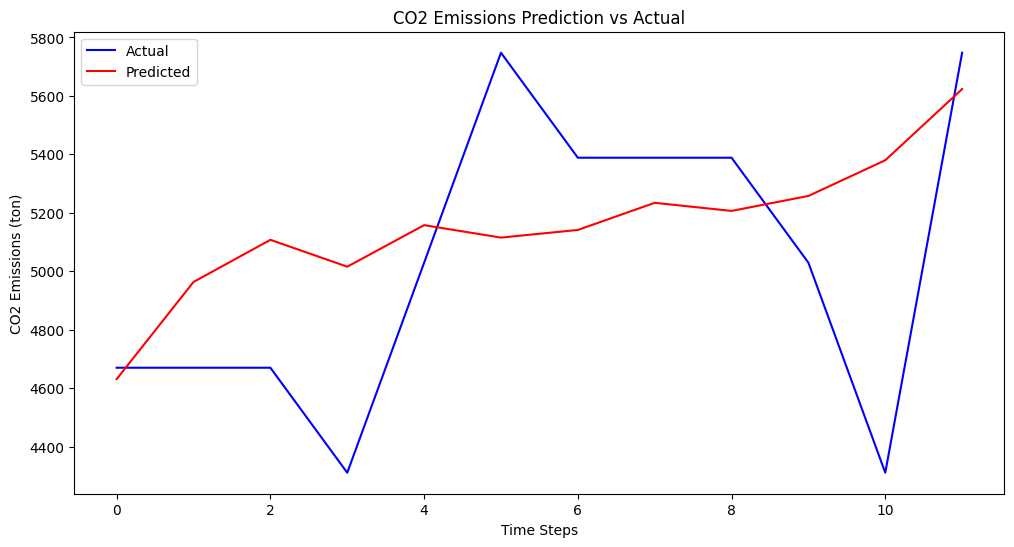

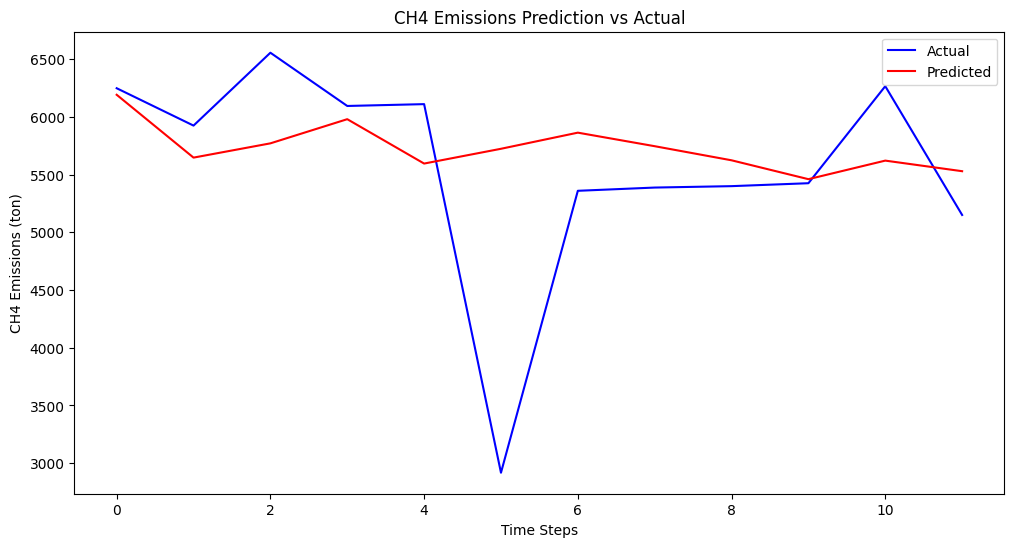

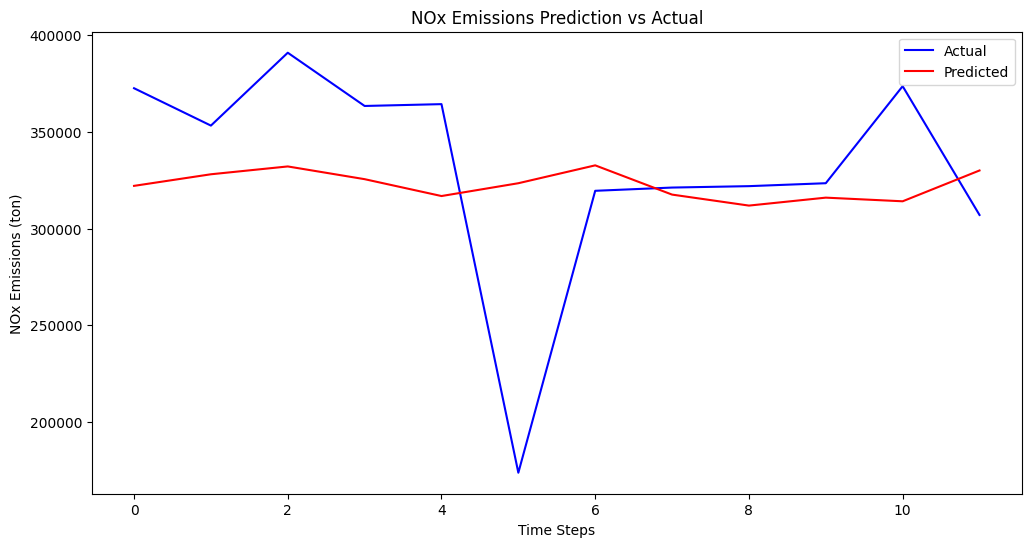

In [ ]:
# Function to plot the predictions vs actual values
def plot_predictions(Y_test, Y_pred, title, ylabel):
    plt.figure(figsize=(12, 6))
    plt.plot(Y_test, label='Actual', color='blue')
    plt.plot(Y_pred, label='Predicted', color='red')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Plot CO2 emissions
plot_predictions(Y_test[:, 0], Y_pred[:, 0], 'CO2 Emissions Prediction vs Actual', 'CO2 Emissions (ton)')

# Plot CH4 emissions
plot_predictions(Y_test[:, 1], Y_pred[:, 1], 'CH4 Emissions Prediction vs Actual', 'CH4 Emissions (ton)')

# Plot NOx emissions
plot_predictions(Y_test[:, 2], Y_pred[:, 2], 'NOx Emissions Prediction vs Actual', 'NOx Emissions (ton)')

In [ ]:
# Select relevant columns
X = data_series[['year', 'month', 'day', 'hour', 'Emisi_CO2_Gas_Alam_1A', 'Emisi_CO2_Listrik_1A', 'produksi_ammonia_ton_1A']]
Y = data_series[['Total_Emisi_CO2_1A', 'Emisi_CH4_1A', 'Emisi_NOx_1A']]

# Scale the data
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_Y = MinMaxScaler()
Y_scaled = scaler_Y.fit_transform(Y)

In [ ]:
# Function to create sequences
def create_sequences(X, Y, time_steps=24):
    Xs, Ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        Ys.append(Y[i+time_steps])
    return np.array(Xs), np.array(Ys)

time_steps = 36  # For example, using 24 hours as a sequence length

X_seq, Y_seq = create_sequences(X_scaled, Y_scaled, time_steps)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_seq, Y_seq, test_size=0.2, random_state=42)

In [ ]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(3))  # Output layer with 3 neurons (one for each variable)
model.compile(loss='mae', optimizer='adam')

In [ ]:
# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/50
2/2 [==============================] - 3s 555ms/step - loss: 0.7703 - val_loss: 0.6315
Epoch 2/50
2/2 [==============================] - 0s 45ms/step - loss: 0.6676 - val_loss: 0.5526
Epoch 3/50
2/2 [==============================] - 0s 45ms/step - loss: 0.5699 - val_loss: 0.4679
Epoch 4/50
2/2 [==============================] - 0s 45ms/step - loss: 0.4632 - val_loss: 0.3820
Epoch 5/50
2/2 [==============================] - 0s 46ms/step - loss: 0.3584 - val_loss: 0.3011
Epoch 6/50
2/2 [==============================] - 0s 44ms/step - loss: 0.2738 - val_loss: 0.2685
Epoch 7/50
2/2 [==============================] - 0s 44ms/step - loss: 0.2222 - val_loss: 0.2529
Epoch 8/50
2/2 [==============================] - 0s 60ms/step - loss: 0.2269 - val_loss: 0.2561
Epoch 9/50
2/2 [==============================] - 0s 55ms/step - loss: 0.2311 - val_loss: 0.2422
Epoch 10/50
2/2 [==============================] - 0s 46ms/step - loss: 0.2163 - val_loss: 0.2364
Epoch 11/50
2/2 [===========

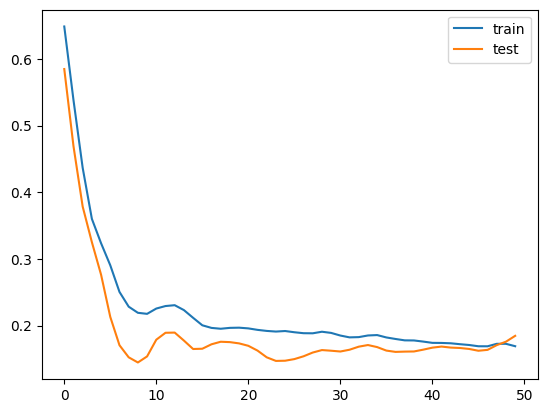

In [ ]:
# Plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# Make predictions
Y_pred = model.predict(X_test)

# Inverse transform predictions
Y_pred = scaler_Y.inverse_transform(Y_pred)

# Inverse transform test labels
Y_test = scaler_Y.inverse_transform(Y_test)

1/1 [==============================] - 1s 551ms/step


In [ ]:
# Output predictions and actual values for comparison
print("Predicted Emissions vs Actual Emissions")
print(np.concatenate((Y_pred, Y_test), axis=1))

Predicted Emissions vs Actual Emissions
[[  5207.17626953   5645.60693359 316311.625        5388.4935
    6008.98682059 358135.61450745]
 [  4911.20556641   5826.62109375 329923.65625      5388.4935
    5404.97256028 322136.36459272]
 [  5009.12207031   5854.27001953 330364.8125       4310.7948
    6267.85312064 373564.04599019]
 [  4869.20654297   5871.41796875 334955.0625       5388.4935
    5392.82488051 321412.36287835]
 [  5199.78173828   5564.56494141 320115.           5388.4935
    5493.24750174 327397.55110363]
 [  5058.66845703   5573.28076172 318618.59375      5388.4935
    5441.81897836 324332.41111001]
 [  5040.09619141   5506.51123047 322165.           5747.7264
    5543.19295349 330374.30002826]
 [  5026.41748047   5399.22265625 319825.5          5388.4935
    5630.85327752 335598.85534005]
 [  4789.36279297   5674.71435547 320940.40625      5388.4935
    6341.29132141 377940.96275621]
 [  5397.78369141   5708.25146484 314667.6875       4310.7948
    5963.42068604 355419.

In [ ]:
# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def evaluate_metrics(true_values, predictions):
    mae = mean_absolute_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)
    return mae, r2

# Evaluate CO2
mae_CO2, r2_CO2 = evaluate_metrics(Y_test[:, 0], Y_pred[:, 0])
print(f'CO2 - MAE: {mae_CO2}, R2: {r2_CO2}')
# Evaluate NOx
mae_NOx, r2_NOx = evaluate_metrics(Y_test[:, 2], Y_pred[:, 2])
print(f'NOx - MAE: {mae_NOx}, R2: {r2_NOx}')


CO2 - MAE: 515.0582022656247, R2: -0.5661220651908887
NOx - MAE: 24108.498000270727, R2: -1.1607484306578062


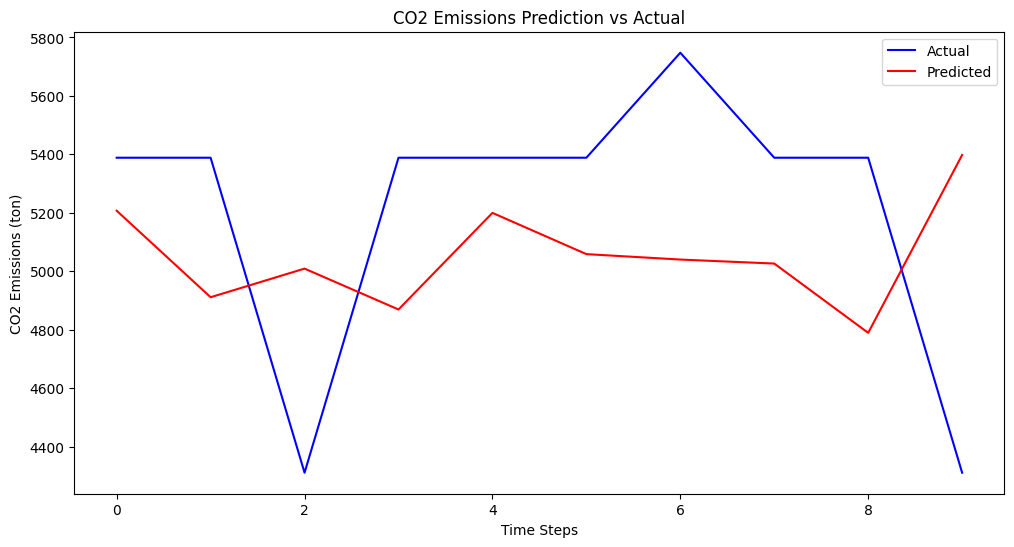

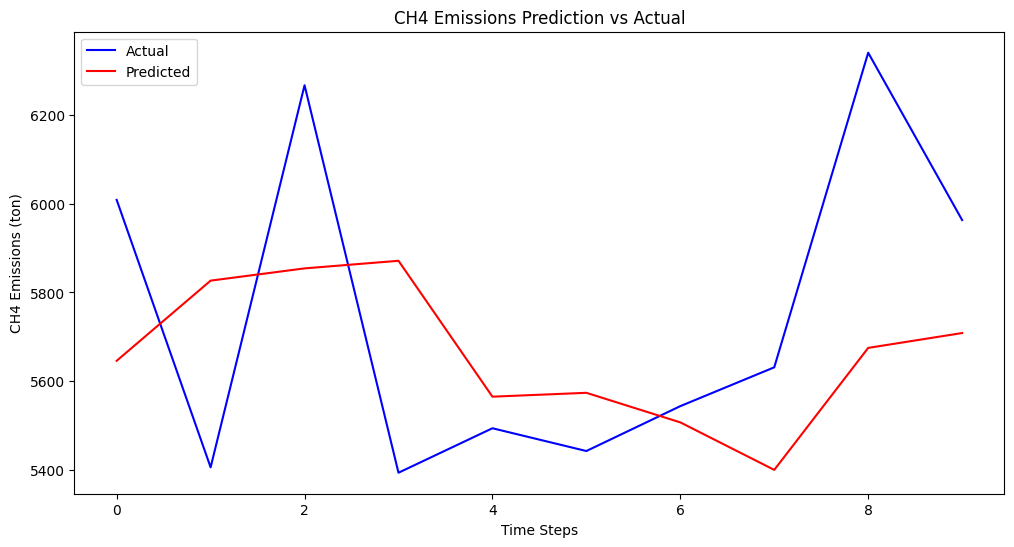

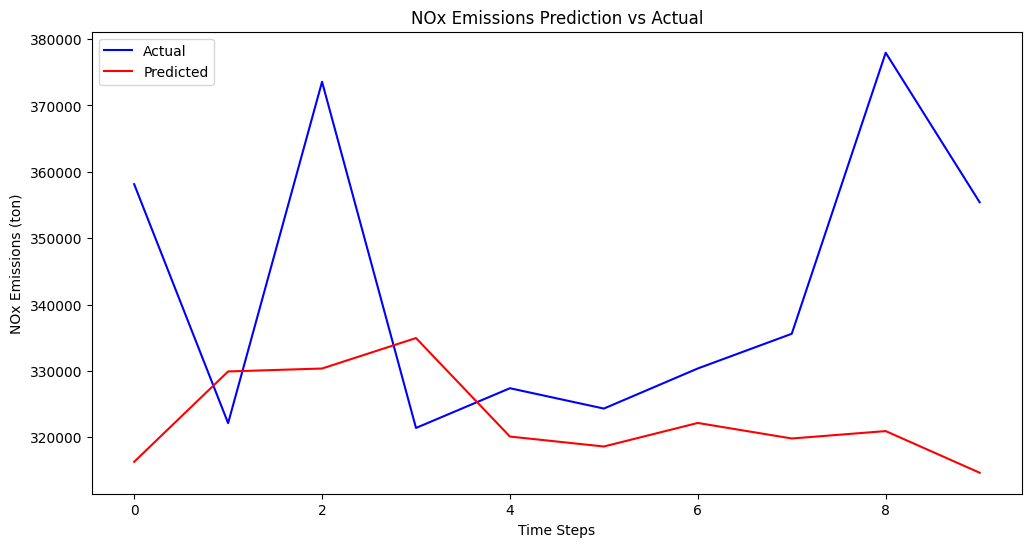

In [ ]:
import matplotlib.pyplot as plt

# Function to plot the predictions vs actual values
def plot_predictions(Y_test, Y_pred, title, ylabel):
    plt.figure(figsize=(12, 6))
    plt.plot(Y_test, label='Actual', color='blue')
    plt.plot(Y_pred, label='Predicted', color='red')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Plot CO2 emissions
plot_predictions(Y_test[:, 0], Y_pred[:, 0], 'CO2 Emissions Prediction vs Actual', 'CO2 Emissions (ton)')

# Plot CH4 emissions
plot_predictions(Y_test[:, 1], Y_pred[:, 1], 'CH4 Emissions Prediction vs Actual', 'CH4 Emissions (ton)')

# Plot NOx emissions
plot_predictions(Y_test[:, 2], Y_pred[:, 2], 'NOx Emissions Prediction vs Actual', 'NOx Emissions (ton)')

In [ ]:
# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Frame as supervised learning
n_hours = 24
n_features = values.shape[1]
reframed = series_to_supervised(scaled, n_hours, 1)

# Drop columns we don't want to predict
reframed.drop(reframed.columns[[i for i in range(n_features*n_hours, n_features*n_hours + (n_features - 3))]], axis=1, inplace=True)
print(reframed.head())

    var1(t-24)  var2(t-24)  var3(t-24)  var4(t-24)  var5(t-24)  var6(t-24)  \
24         0.0    0.000000    0.333333       0.125         0.5         0.5   
25         0.0    0.090909    0.000000       0.500         0.0         0.0   
26         0.0    0.090909    0.800000       0.250         0.0         0.0   
27         0.0    0.181818    0.100000       0.000         1.0         1.0   
28         0.0    0.272727    0.100000       0.500         0.0         0.0   

    var7(t-24)  var8(t-24)  var9(t-24)  var10(t-24)  ...  var4(t-1)  \
24    0.774767         0.5    0.774767     0.774767  ...      0.375   
25    0.764815         0.0    0.764815     0.764814  ...      0.750   
26    0.784765         0.0    0.784765     0.784765  ...      0.125   
27    0.585662         1.0    0.585662     0.585662  ...      0.375   
28    0.605313         0.0    0.605313     0.605313  ...      0.625   

    var5(t-1)  var6(t-1)  var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  \
24       0.25       0.25   0.77

In [ ]:
# Split into train and test sets
values = reframed.values
n_train_hours = int(len(values) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# Split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -3:]
test_X, test_y = test[:, :n_obs], test[:, -3:]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(48, 24, 10) (48, 3) (13, 24, 10) (13, 3)


In [ ]:
# Design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(3))
model.compile(loss='mae', optimizer='adam')

In [ ]:
# Fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/50
1/1 - 3s - loss: 0.6282 - val_loss: 0.5882 - 3s/epoch - 3s/step
Epoch 2/50
1/1 - 0s - loss: 0.5681 - val_loss: 0.5309 - 44ms/epoch - 44ms/step
Epoch 3/50
1/1 - 0s - loss: 0.5088 - val_loss: 0.4728 - 41ms/epoch - 41ms/step
Epoch 4/50
1/1 - 0s - loss: 0.4486 - val_loss: 0.4133 - 42ms/epoch - 42ms/step
Epoch 5/50
1/1 - 0s - loss: 0.3867 - val_loss: 0.3518 - 40ms/epoch - 40ms/step
Epoch 6/50
1/1 - 0s - loss: 0.3262 - val_loss: 0.2952 - 41ms/epoch - 41ms/step
Epoch 7/50
1/1 - 0s - loss: 0.2763 - val_loss: 0.2530 - 41ms/epoch - 41ms/step
Epoch 8/50
1/1 - 0s - loss: 0.2460 - val_loss: 0.2276 - 43ms/epoch - 43ms/step
Epoch 9/50
1/1 - 0s - loss: 0.2308 - val_loss: 0.2150 - 43ms/epoch - 43ms/step
Epoch 10/50
1/1 - 0s - loss: 0.2252 - val_loss: 0.2167 - 51ms/epoch - 51ms/step
Epoch 11/50
1/1 - 0s - loss: 0.2274 - val_loss: 0.2189 - 51ms/epoch - 51ms/step
Epoch 12/50
1/1 - 0s - loss: 0.2290 - val_loss: 0.2183 - 45ms/epoch - 45ms/step
Epoch 13/50
1/1 - 0s - loss: 0.2252 - val_loss: 0.213

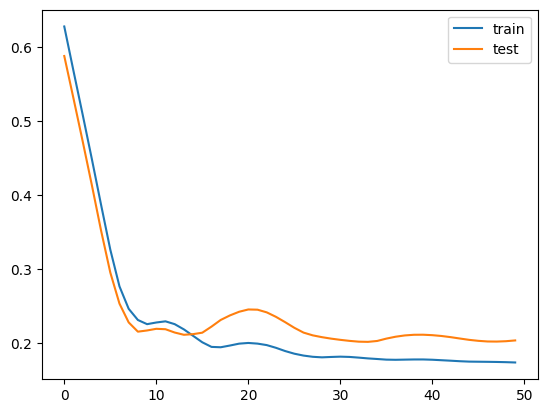

In [ ]:
# Plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
test_X.shape

(13, 240)

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

TypeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/lstm.py", line 616, in call
        timesteps = input_shape[0] if self.time_major else input_shape[1]

    TypeError: Exception encountered when calling layer 'lstm' (type LSTM).
    
    'NoneType' object is not subscriptable
    
    Call arguments received by layer 'lstm' (type LSTM):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • mask=None
      • training=False
      • initial_state=None
